Phase 1 (Data Preparation)

⚠️ Before running, make sure you open this shared dataset link:
[Shared Dataset Link](https://drive.google.com/drive/folders/1qITcchaDUSl2Yn7b0Dzsp2UT_i9Qaevg?usp=sharing)

Then add it to your own Drive (Right-click → Add shortcut to Drive).


In [5]:
# Cell: mount drive & set base_dir
from google.colab import drive
import os, glob, json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
BASE_DIR = "/content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled"

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError(f"{BASE_DIR} not found. Check path in Drive.")
print("✅ Dataset found at:", BASE_DIR)


✅ Dataset found at: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled


In [7]:
# ==========================================
# Phase 1: Data Preparation - Imports
# ==========================================

# File & folder handling
import os
import glob
import random
from collections import Counter

# Image processing
import cv2
import numpy as np

# Data analysis & utilities
import pandas as pd
from tqdm import tqdm   # nice progress bar (pip install tqdm if missing)

# Visualization
import matplotlib.pyplot as plt



In [12]:
#  list people folders inside BASE_DIR
people = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
print("Number of people folders:", len(people))  # should be ~5749







Number of people folders: 5749


Total people: 5749
Total images: 13233
Average images per person: 2.301791615933206
Median images per person: 1.0
Total people: 5749
Total images: 13233
Average images per person: 2.301791615933206
Median images per person: 1.0


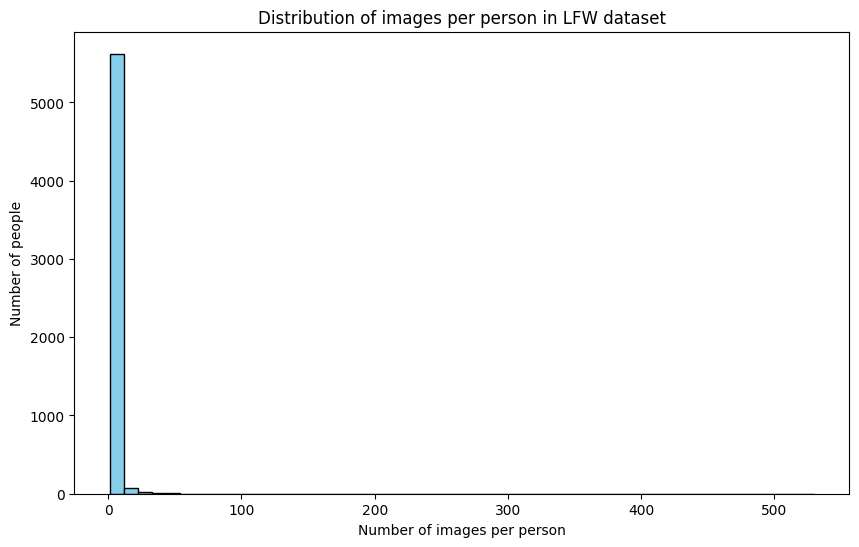

Top 10 people by number of images:
                 person  count
3121      George_W_Bush    530
4298       Colin_Powell    236
709          Tony_Blair    144
4644    Donald_Rumsfeld    121
3142  Gerhard_Schroeder    109
5370       Ariel_Sharon     77
3424        Hugo_Chavez     71
2191  Junichiro_Koizumi     60
3722      Jean_Chretien     55
3938      John_Ashcroft     53


In [18]:
#  count images per person
counts = {p: len(os.listdir(os.path.join(BASE_DIR, p))) for p in people}

counts_df = pd.DataFrame(list(counts.items()), columns=["person", "count"])

# Quick stats
print("Total people:", len(counts_df))
print("Total images:", counts_df["count"].sum())
print("Average images per person:", counts_df["count"].mean())
print("Median images per person:", counts_df["count"].median())

# Quick stats
print("Total people:", len(counts_df))
print("Total images:", counts_df["count"].sum())
print("Average images per person:", counts_df["count"].mean())
print("Median images per person:", counts_df["count"].median())




# Histogram

plt.figure(figsize=(10,6))
plt.hist(counts_df["count"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Number of images per person")
plt.ylabel("Number of people")
plt.title("Distribution of images per person in LFW dataset")
plt.show()



# Top 10 people by count
print("Top 10 people by number of images:")
print(counts_df.sort_values("count", ascending=False).head(10))


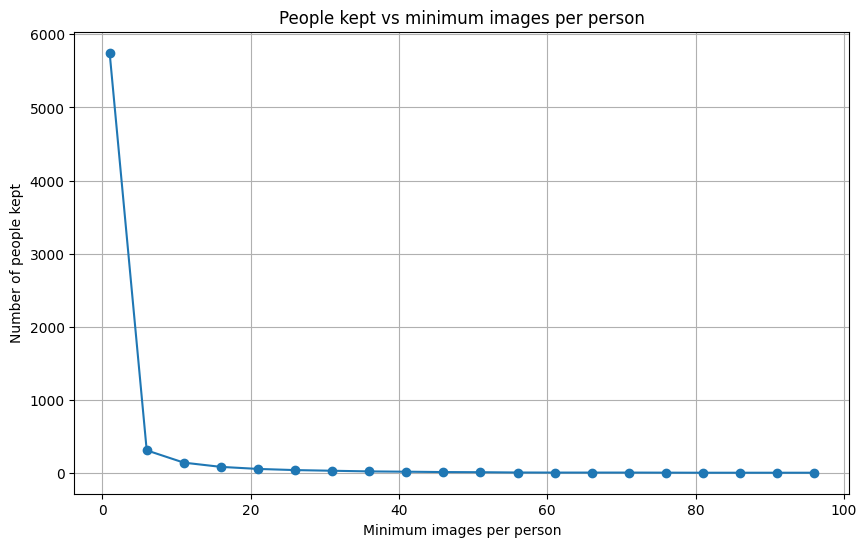

[(np.int64(1), np.int64(5749)),
 (np.int64(6), np.int64(311)),
 (np.int64(11), np.int64(143)),
 (np.int64(16), np.int64(85)),
 (np.int64(21), np.int64(57)),
 (np.int64(26), np.int64(41)),
 (np.int64(31), np.int64(32)),
 (np.int64(36), np.int64(23)),
 (np.int64(41), np.int64(19)),
 (np.int64(46), np.int64(14))]

In [19]:

thresholds = np.arange(1, 101, 5)  # from 1 to 100 in steps of 5
people_counts = [(t, (counts_df["count"] >= t).sum()) for t in thresholds]

# Plot
plt.figure(figsize=(10,6))
plt.plot([t for t, c in people_counts], [c for t, c in people_counts], marker="o")
plt.xlabel("Minimum images per person")
plt.ylabel("Number of people kept")
plt.title("People kept vs minimum images per person")
plt.grid(True)
plt.show()

# Show first few values
people_counts[:10]


In [20]:
MIN_IMAGES = 10  # our chosen cutoff

valid_people = counts_df[counts_df["count"] >= MIN_IMAGES]["person"].tolist()
print(f"Number of valid people (>= {MIN_IMAGES} images):", len(valid_people))


Number of valid people (>= 10 images): 158


In [21]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = (160, 160)

X, y = [], []

for person in tqdm(valid_people, desc="Loading subset"):
    folder = os.path.join(BASE_DIR, person)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        if img is None:
            continue
        # Resize & normalize
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype("float32") / 255.0
        X.append(img)
        y.append(person)

X = np.array(X)
y = np.array(y)

print("✅ Subset loaded & preprocessed")
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique identities:", len(np.unique(y)))


Loading subset: 100%|██████████| 158/158 [13:47<00:00,  5.24s/it]


✅ Subset loaded & preprocessed
Images shape: (4324, 160, 160, 3)
Labels shape: (4324,)
Unique identities: 158


In [22]:
SAVE_DIR = "/content/drive/MyDrive/processed_lfw"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "X.npy"), X)
np.save(os.path.join(SAVE_DIR, "y.npy"), y)

print("✅ Saved X.npy and y.npy to:", SAVE_DIR)


✅ Saved X.npy and y.npy to: /content/drive/MyDrive/processed_lfw


George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64


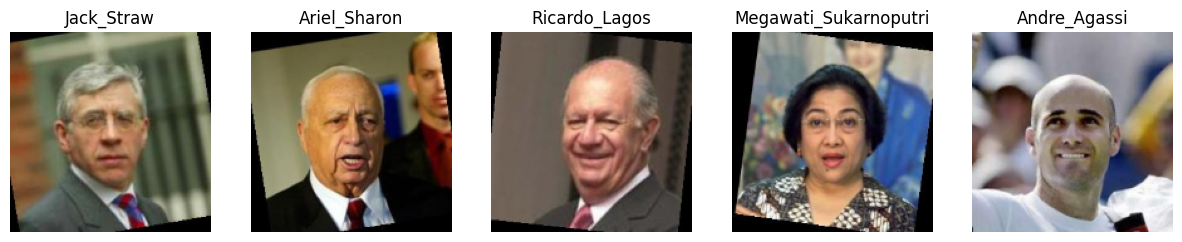

In [23]:
# Class distribution (top 10 people)
print(pd.Series(y).value_counts().head(10))

# Show 5 random images
fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    idx = random.randint(0, len(X)-1)
    ax[i].imshow(X[idx])
    ax[i].set_title(y[idx])
    ax[i].axis("off")
plt.show()


Phase 2 – EDA + Feature Building

We use DeepFace to extract face embeddings from images with pre-trained models (e.g., FaceNet). This lets us leverage transfer learning instead of training a deep network from scratch, making our project faster and more accurate.

In [29]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00


In [44]:
!pip install albumentations==1.3.1 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.5 MB/s eta 0:00:00


In [30]:
# ==========================================
# Phase 2: EDA + Feature Engineering Imports
# ==========================================

# Data analysis & visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Image processing & augmentation
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Progress bar
from tqdm import tqdm

# Feature engineering (scaling, embeddings, dimensionality reduction)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep learning face embeddings
from deepface import DeepFace



25-09-24 17:55:05 - Directory /root/.deepface has been created
25-09-24 17:55:05 - Directory /root/.deepface/weights has been created


In [32]:
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique identities:", len(np.unique(y)))


Images shape: (4324, 160, 160, 3)
Labels shape: (4324,)
Unique identities: 158


Top 10 people with most images:
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64


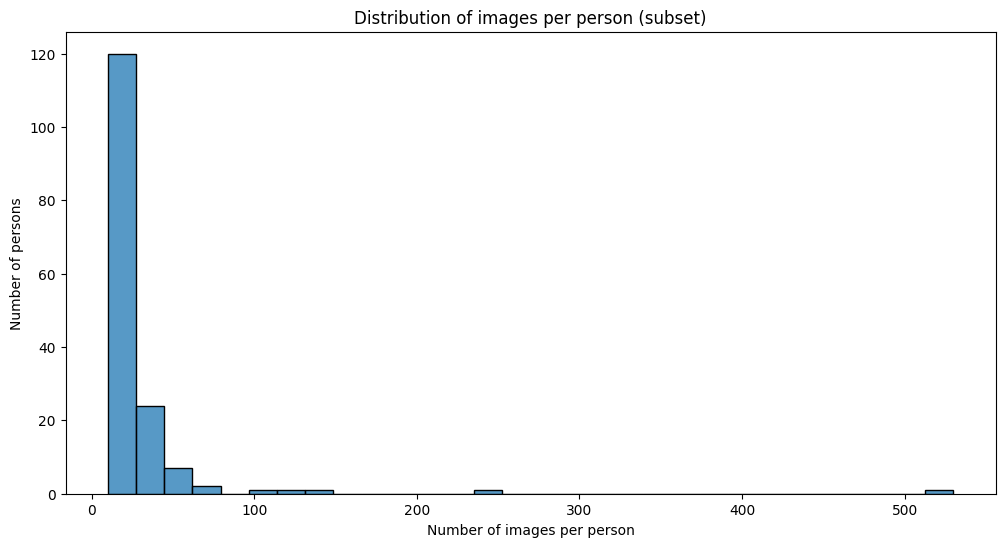

In [34]:
label_counts = pd.Series(y).value_counts()

print("Top 10 people with most images:")
print(label_counts.head(10))

# Plot distribution
plt.figure(figsize=(12,6))
sns.histplot(label_counts, bins=30, kde=False)
plt.xlabel("Number of images per person")
plt.ylabel("Number of persons")
plt.title("Distribution of images per person (subset)")
plt.show()


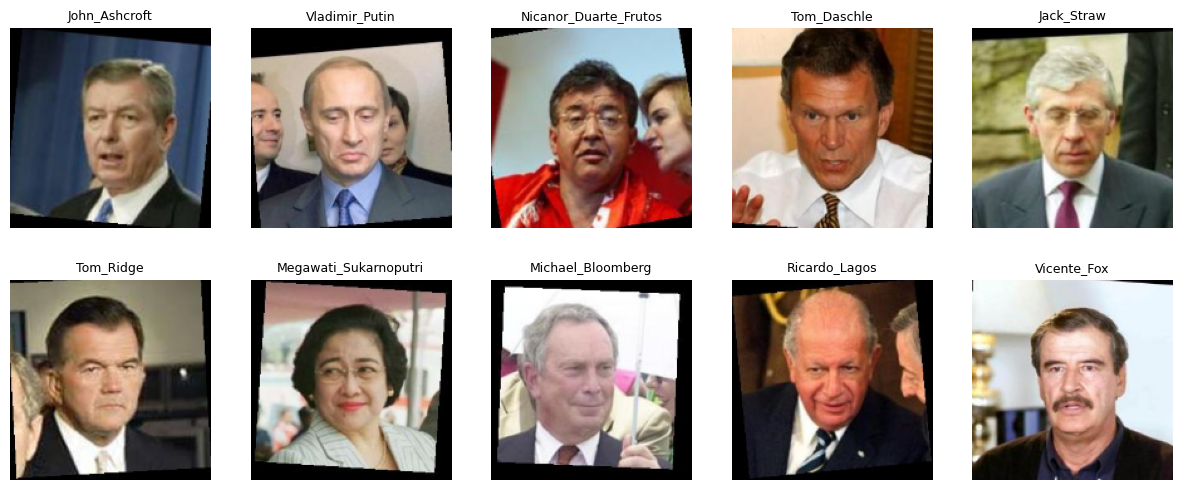

In [36]:
fig, ax = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    idx = random.randint(0, len(X)-1)
    ax[i//5, i%5].imshow(X[idx])
    ax[i//5, i%5].set_title(y[idx], fontsize=9)
    ax[i//5, i%5].axis("off")
plt.show()


In [37]:
print("Average images per person:", label_counts.mean())
print("Median images per person:", label_counts.median())


Average images per person: 27.367088607594937
Median images per person: 17.0


In [47]:
import os, glob

image_paths, labels = [], []
for person in valid_people:
    folder = os.path.join(BASE_DIR, person)
    imgs = sorted(glob.glob(os.path.join(folder, "*.jpg")))
    for p in imgs:
        image_paths.append(p)
        labels.append(person)

print("Total images collected:", len(image_paths))
print("Example:", image_paths[0], "->", labels[0])


Total images collected: 4324
Example: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Roger_Federer/Roger_Federer_0001.jpg -> Roger_Federer


In [40]:
MODEL_NAME = "Facenet512"


embeddings, labels = [], []

for person in tqdm(valid_people):
    folder = os.path.join(BASE_DIR, person)
    imgs = glob.glob(os.path.join(folder, "*.jpg"))
    for img in imgs:
        try:
            rep = DeepFace.represent(img_path=img, model_name=MODEL_NAME, enforce_detection=False)
            embeddings.append(rep[0]["embedding"])
            labels.append(person)
        except Exception as e:
            print("Error with", img, ":", e)

embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


  0%|          | 0/158 [00:00<?, ?it/s]

25-09-24 18:10:47 - 🔗 facenet512_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5 to /root/.deepface/weights/facenet512_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
 15%|█▍        | 14.2M/95.0M [00:00<00:00, 138MB/s]
 49%|████▊     | 46.1M/95.0M [00:00<00:00, 242MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 265MB/s]
100%|██████████| 158/158 [40:31<00:00, 15.39s/it]

Embeddings shape: (4324, 512)


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

print("Scaled embeddings shape:", embeddings_scaled.shape)


Scaled embeddings shape: (4324, 512)


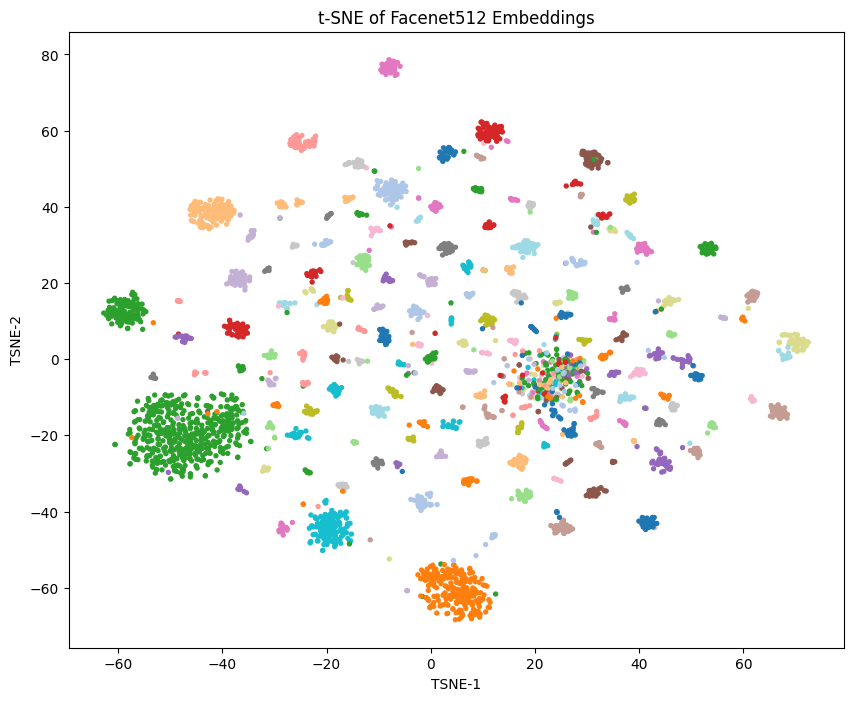

In [42]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# PCA → 50D
pca = PCA(n_components=50)
vis_pca = pca.fit_transform(embeddings_scaled)

# t-SNE → 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
vis_tsne = tsne.fit_transform(vis_pca)

# Map labels to integers
label_to_idx = {lab: idx for idx, lab in enumerate(sorted(set(labels)))}
y = np.array([label_to_idx[l] for l in labels])

# Plot
plt.figure(figsize=(10,8))
plt.scatter(vis_tsne[:,0], vis_tsne[:,1], c=y, s=8, cmap="tab20")
plt.title("t-SNE of Facenet512 Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()


In [43]:
#Save Embadding
import numpy as np

np.savez_compressed("facenet512_embeddings.npz",
                    embeddings=embeddings,
                    embeddings_scaled=embeddings_scaled,
                    labels=np.array(labels))


In [45]:
import albumentations as A
import cv2
import random

# Augmentations for robustness
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
])


In [48]:
aug_embeddings, aug_labels = [], []

# Take a sample of 1000 images for augmentation
sample_idx = random.sample(range(len(image_paths)), k=1000)

for idx in tqdm(sample_idx):
    img_path = image_paths[idx]
    label = labels[idx]

    # Read and augment
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = augment(image=img)["image"]

    # Save temporarily for DeepFace
    tmp_path = "/tmp/aug.jpg"
    cv2.imwrite(tmp_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

    try:
        rep = DeepFace.represent(
            img_path=tmp_path,
            model_name="Facenet512",
            enforce_detection=False
        )
        aug_embeddings.append(rep[0]["embedding"])
        aug_labels.append(label)
    except Exception as e:
        print("Error with", img_path, ":", e)

aug_embeddings = np.array(aug_embeddings)
print("Augmented embeddings shape:", aug_embeddings.shape)


100%|██████████| 1000/1000 [09:11<00:00,  1.81it/s]

Augmented embeddings shape: (1000, 512)


In [50]:
aug_embeddings_scaled = scaler.transform(aug_embeddings)

print("Original embeddings shape:", embeddings_scaled.shape)
print("Augmented embeddings shape:", aug_embeddings_scaled.shape)


Original embeddings shape: (4324, 512)
Augmented embeddings shape: (1000, 512)


In [51]:
## Saving
import numpy as np

# Save original embeddings
np.savez_compressed("facenet512_embeddings.npz",
                    embeddings=embeddings,
                    embeddings_scaled=embeddings_scaled,
                    labels=np.array(labels))

# Save augmented embeddings
np.savez_compressed("facenet512_aug_embeddings.npz",
                    aug_embeddings=aug_embeddings,
                    aug_embeddings_scaled=aug_embeddings_scaled,
                    aug_labels=np.array(aug_labels))

print("✅ All embeddings saved: facenet512_embeddings.npz and facenet512_aug_embeddings.npz")


✅ All embeddings saved: facenet512_embeddings.npz and facenet512_aug_embeddings.npz


In [54]:
import numpy as np
import os

SAVE_DIR = "artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)

# Split into two halves
mid = len(embeddings_scaled) // 2

np.savez_compressed(os.path.join(SAVE_DIR, "facenet512_embeddings_part1.npz"),
                    embeddings_scaled=embeddings_scaled[:mid],
                    labels=np.array(labels[:mid]))

np.savez_compressed(os.path.join(SAVE_DIR, "facenet512_embeddings_part2.npz"),
                    embeddings_scaled=embeddings_scaled[mid:],
                    labels=np.array(labels[mid:]))

print("✅ Saved in two parts:", SAVE_DIR)


✅ Saved in two parts: artifacts


## 📌 Note on Saved Embeddings

⚠️ Extracting embeddings with DeepFace (Facenet512) takes **40+ minutes**.  
To save time, we already ran this step once and stored the results as `.npz` files.

### Files in the repo:
- `facenet512_embeddings_part1.npz` + `facenet512_embeddings_part2.npz`  
  → Original embeddings (4324 × 512), **split into two parts** because GitHub does not allow files larger than 25 MB.  
- `facenet512_aug_embeddings.npz`  
  → Augmented embeddings (1000 × 512).

---

### ✅ How to load them

```python
# Load and regroup split original embeddings
part1 = np.load("artifacts/facenet512_embeddings_part1.npz", allow_pickle=True)
part2 = np.load("artifacts/facenet512_embeddings_part2.npz", allow_pickle=True)

embeddings_scaled = np.vstack([part1["embeddings_scaled"], part2["embeddings_scaled"]])
labels = np.hstack([part1["labels"], part2["labels"]])

print("✅ Reloaded split embeddings:", embeddings_scaled.shape)

# Load augmented embeddings
aug_data = np.load("artifacts/facenet512_aug_embeddings.npz", allow_pickle=True)
aug_embeddings = aug_data["aug_embeddings"]
aug_embeddings_scaled = aug_data["aug_embeddings_scaled"]
aug_labels = aug_data["aug_labels"]

print("✅ Augmented embeddings loaded:", aug_embeddings.shape)


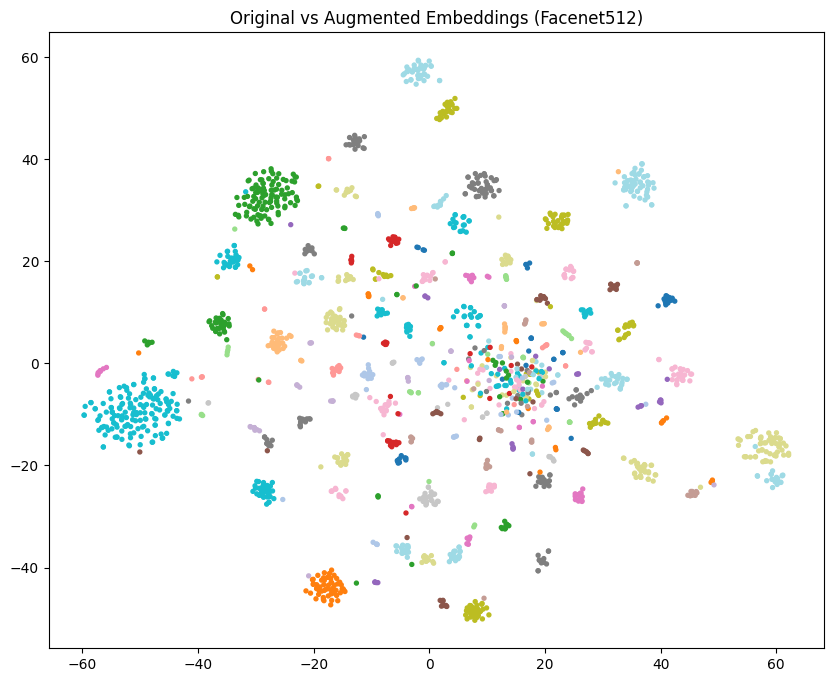

In [52]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine 1000 original + 1000 augmented for comparison
all_emb = np.vstack([embeddings_scaled[:1000], aug_embeddings_scaled])
all_labels = np.hstack([y[:1000], [label_to_idx[l] for l in aug_labels]])

# Reduce to 50D with PCA
pca = PCA(n_components=50)
pca_emb = pca.fit_transform(all_emb)

# Then t-SNE to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_emb = tsne.fit_transform(pca_emb)

plt.figure(figsize=(10,8))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=all_labels, s=8, cmap="tab20")
plt.title("Original vs Augmented Embeddings (Facenet512)")
plt.show()
